In google colab, for the code to run, you need to uninstall tensorflow 2.11.0 and install tensorflow 2.9

In [1]:
import tensorflow as tf
print(tf.__version__)

2.11.0


In [2]:
!pip uninstall tensorflow

Found existing installation: tensorflow 2.11.0
Uninstalling tensorflow-2.11.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.8/dist-packages/tensorflow-2.11.0.dist-info/*
    /usr/local/lib/python3.8/dist-packages/tensorflow/*
Proceed (Y/n)? Y 
  Successfully uninstalled tensorflow-2.11.0


In [3]:
!pip install tensorflow==2.9

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 73.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 75.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 KB 43.1 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.11.0
    Uninstalling keras-2.11.0:
      Successfully uninstalled keras-2.11.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.1.21
    Uninstalling flatbuffers-23.1.21:
      Successfully uninstalled flatbuffers-23.1.21
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.11.0
    Uninstalling tensorflow-estimator-2.11.0:
      Successfully u

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Import all the Dependencies**

In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

**Set all the Constants**

In [3]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

**Import data into tensorflow dataset object**

In [ ]:
#directory= "drive/MyDrive/Plant village  potatoes/PlantVillage"
directory= "drive/MyDrive/Plant_leaf_diseases_dataset_mendeley_potatoes/Plant_leave_diseases_dataset_without_augmentation"
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory,
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [ ]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [ ]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


**Data Vizualization and exploration**

In [ ]:
import pandas as pd
dataset_unbatched = tuple(dataset.unbatch())
labels = []
for (image,label) in dataset_unbatched:
    labels.append(label.numpy())
labels = pd.Series(labels)

# adjustments
count = labels.value_counts().sort_index()
count.index = dataset.class_names
print(count)

Potato___Early_blight    1000
Potato___Late_blight     1000
Potato___healthy          152
dtype: int64


Convert the series created above to a dataframe for easier plotting

In [ ]:
df_potatoes= pd.DataFrame({'Class_name':count.index, 'images_count':count.values})
print(df_potatoes)

              Class_name  images_count
0  Potato___Early_blight          1000
1   Potato___Late_blight          1000
2       Potato___healthy           152


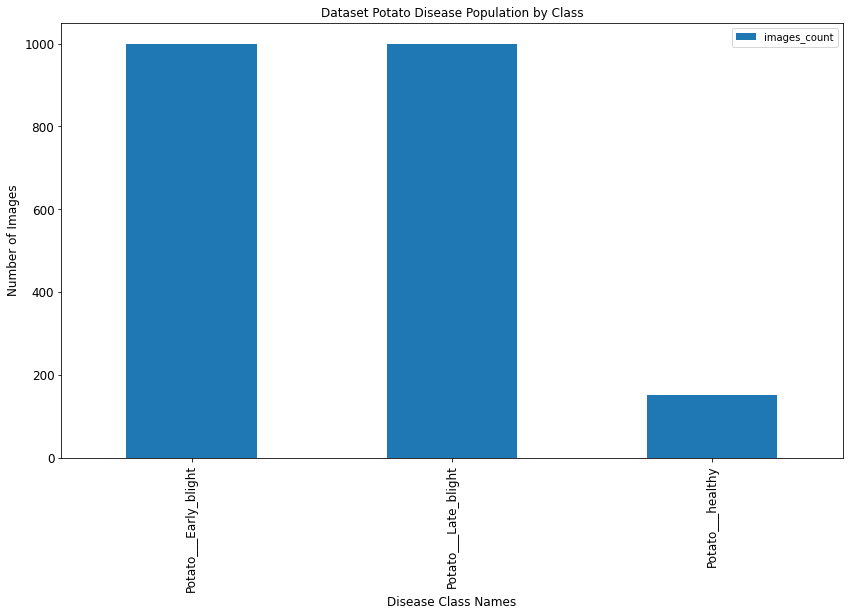

In [ ]:
#visualize the data as a bar chart
import matplotlib.pyplot as plt
#make Class_name the index
df_potatoes= df_potatoes.set_index('Class_name')
ax = df_potatoes['images_count'].plot(kind='bar', title ="Dataset Potato Disease Population by Class", figsize=(14,8), legend=True, fontsize=12)
ax.set_xlabel("Disease Class Names", fontsize=12)
ax.set_ylabel("Number of Images", fontsize=12)
plt.show()

In [ ]:
#reset the index of the dataframe to initial state
df_potatoes= df_potatoes.reset_index()

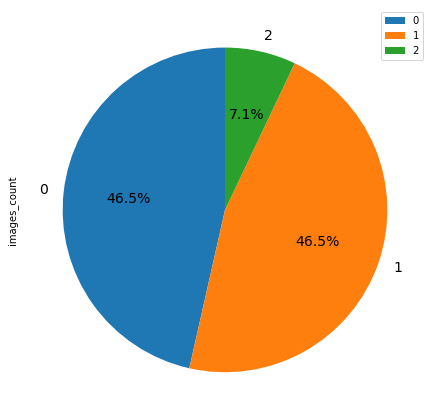

              Class_name  images_count
0  Potato___Early_blight          1000
1   Potato___Late_blight          1000
2       Potato___healthy           152


In [ ]:
#visualize the data as a pie chart
plt.figure(figsize=(16,8))
# plot chart
ax1 = plt.subplot(121, aspect='equal')
df_potatoes.plot(kind='pie', y = 'images_count', ax=ax1, autopct='%1.1f%%', 
 startangle=90, shadow=False, legend = True, fontsize=14)
plt.show()
#print dataframe to understand legend
print(df_potatoes)

**Further Preprocessin**g

because the dataset is seriously imbalanced, data augmentation would be done later to mitigate this

**Visualize some of the images from our dataset**

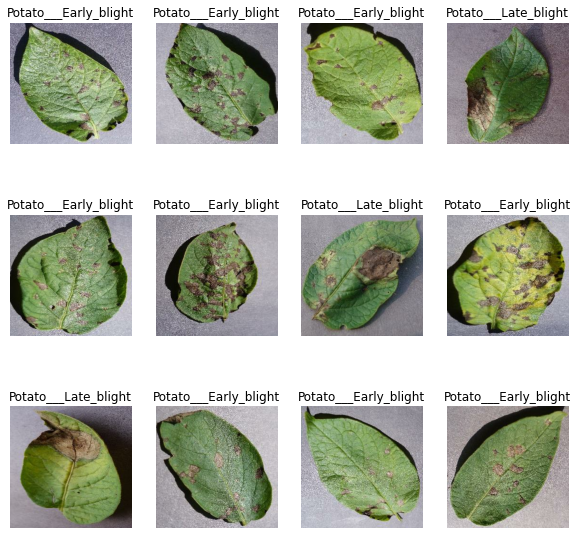

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

**Function to Split Dataset**

In [ ]:
len(dataset)

68

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

**Cache, Shuffle, and Prefetch the Dataset**

Creating a Layer for Resizing and Normalization

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

**Data Augmentation**

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

**Applying Data Augmentation to Train Dataset**

In [ ]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

**Model Architecture**

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

**Compiling the Model**

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 [==============================] - 121s 80ms/step - loss: 0.9095 - accuracy: 0.4759 - val_loss: 0.8483 - val_accuracy: 0.4635
Epoch 2/50
54/54 [==============================] - 5s 77ms/step - loss: 0.7840 - accuracy: 0.6009 - val_loss: 0.5742 - val_accuracy: 0.8095
Epoch 3/50
54/54 [==============================] - 5s 78ms/step - loss: 0.5405 - accuracy: 0.7494 - val_loss: 0.5342 - val_accuracy: 0.7500
Epoch 4/50
54/54 [==============================] - 5s 76ms/step - loss: 0.3721 - accuracy: 0.8457 - val_loss: 0.3528 - val_accuracy: 0.8698
Epoch 5/50
54/54 [==============================] - 5s 78ms/step - loss: 0.2842 - accuracy: 0.8867 - val_loss: 0.2693 - val_accuracy: 0.9115
Epoch 6/50
54/54 [==============================] - 5s 77ms/step - loss: 0.2336 - accuracy: 0.9085 - val_loss: 0.3567 - val_accuracy: 0.8594
Epoch 7/50
54/54 [==============================] - 5s 78ms/step - loss: 0.2624 - accuracy: 0.8944 - val_loss: 0.1641 - val_accuracy: 0.9062
Epoch 8/50


In [ ]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 1s 11ms/step - loss: 0.0605 - accuracy: 0.9766


**Building the various transfer learning models**

The code for these sections was inspired by codebasics code from this link https://github.com/codebasics/potato-disease-classification/blob/main/training/potato-disease-classification-model.ipynb

**I. Buiding the EfficientNetB4 transfer learning model**

Model Artictecture

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB4
from keras.optimizers import Adam
from tensorflow.keras import models, layers


model1 = models.Sequential()
model1.add(EfficientNetB4(include_top = False, weights = 'imagenet',
                             input_shape = (IMAGE_SIZE
                                            , IMAGE_SIZE, 3)))
#Add regularization using the function below
#add_regularization(model1, regularizer=tf.keras.regularizers.l1_l2(0.0001))
    
model1.add(layers.GlobalAveragePooling2D())
model1.add(layers.Dense(CHANNELS, activation = "softmax"))

model1.compile(optimizer = Adam(learning_rate = 0.00001),
                  loss = "sparse_categorical_crossentropy",
                  metrics = ["acc"])

model1.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb4 (Functional)  (None, 8, 8, 1792)       17673823  
                                                                 
 global_average_pooling2d_1   (None, 1792)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 3)                 5379      
                                                                 
Total params: 17,679,202
Trainable params: 17,553,995
Non-trainable params: 125,207
_________________________________________________________________


In [ ]:
import tensorflow as tf



model1_save = ModelCheckpoint('./best_baseline_model1.h5', 
                             save_best_only = True, 
                             save_weights_only = True,
                             monitor = 'val_loss', 
                             mode = 'min', verbose = 1)
early_stop1 = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, 
                           patience = 5, mode = 'min', verbose = 1,
                           restore_best_weights = True)
reduce_lr1 = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.3, 
                              patience = 2, min_delta = 0.001, 
                              mode = 'min', verbose = 1)

the training and plots

In [ ]:
history= model1.fit(train_ds,
                    validation_data= val_ds,
                    batch_size=BATCH_SIZE,
                    verbose=1,
                    epochs= 50,
                    callbacks = [model1_save, early_stop1, reduce_lr1])


# Save the entire model as a SavedModel.
#!mkdir -p saved_model
#model1.save("drive/MyDrive/Plant village  potatoes/saved_model/my_model1")
model1.save("drive/MyDrive/Plant_leaf_diseases_dataset_mendeley_potatoes/saved_model/my_model1")

Epoch 1/50
54/54 [==============================] - ETA: 0s - loss: 0.9323 - acc: 0.6326
Epoch 1: val_loss improved from inf to 0.91056, saving model to ./best_baseline_model1.h5
54/54 [==============================] - 46s 498ms/step - loss: 0.9323 - acc: 0.6326 - val_loss: 0.9106 - val_acc: 0.7865 - lr: 1.0000e-05
Epoch 2/50
54/54 [==============================] - ETA: 0s - loss: 0.6632 - acc: 0.8685
Epoch 2: val_loss improved from 0.91056 to 0.66004, saving model to ./best_baseline_model1.h5
54/54 [==============================] - 25s 438ms/step - loss: 0.6632 - acc: 0.8685 - val_loss: 0.6600 - val_acc: 0.9226 - lr: 1.0000e-05
Epoch 3/50
54/54 [==============================] - ETA: 0s - loss: 0.4404 - acc: 0.9392
Epoch 3: val_loss improved from 0.66004 to 0.41226, saving model to ./best_baseline_model1.h5
54/54 [==============================] - 25s 435ms/step - loss: 0.4404 - acc: 0.9392 - val_loss: 0.4123 - val_acc: 0.9635 - lr: 1.0000e-05
Epoch 4/50
54/54 [====================

Text(0.5, 1.0, 'Accuracy Curves')

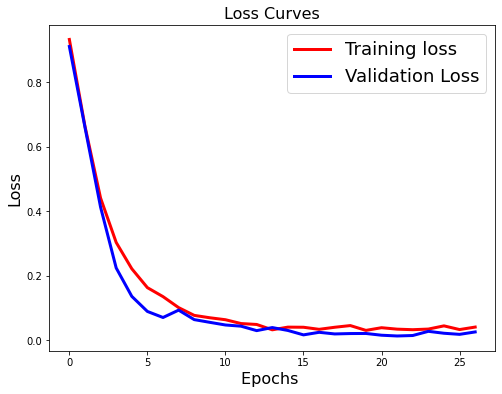

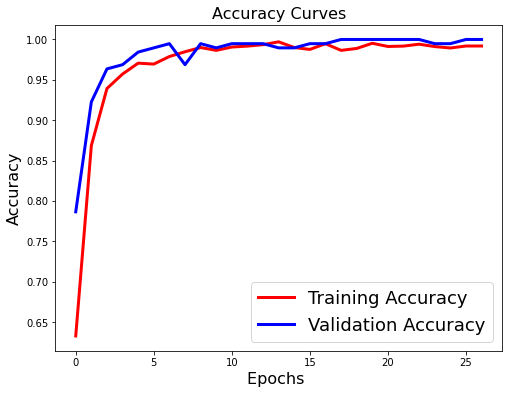

In [ ]:
#Plot the Graph
from matplotlib import pyplot as plt
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']


# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(loss,'r',linewidth=3.0)
plt.plot(val_loss,'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
  
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(accuracy,'r',linewidth=3.0)
plt.plot(val_accuracy,'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)


In [ ]:
#Evaluate model on test_ds
scores = model1.evaluate(test_ds)

8/8 [==============================] - 1s 48ms/step - loss: 0.0212 - acc: 1.0000


Run prediction on a sample image

first image to predict
actual label: Potato___Late_blight
1/1 [==============================] - 3s 3s/step
predicted label: Potato___Late_blight


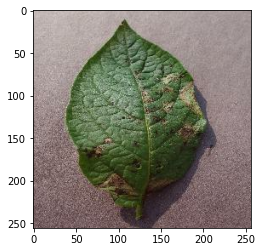

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model1.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

Write a function for inference

In [ ]:
import numpy as np
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img.numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)


    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

Now run inference on a few sample images

1/1 [==============================] - 0s 39ms/step


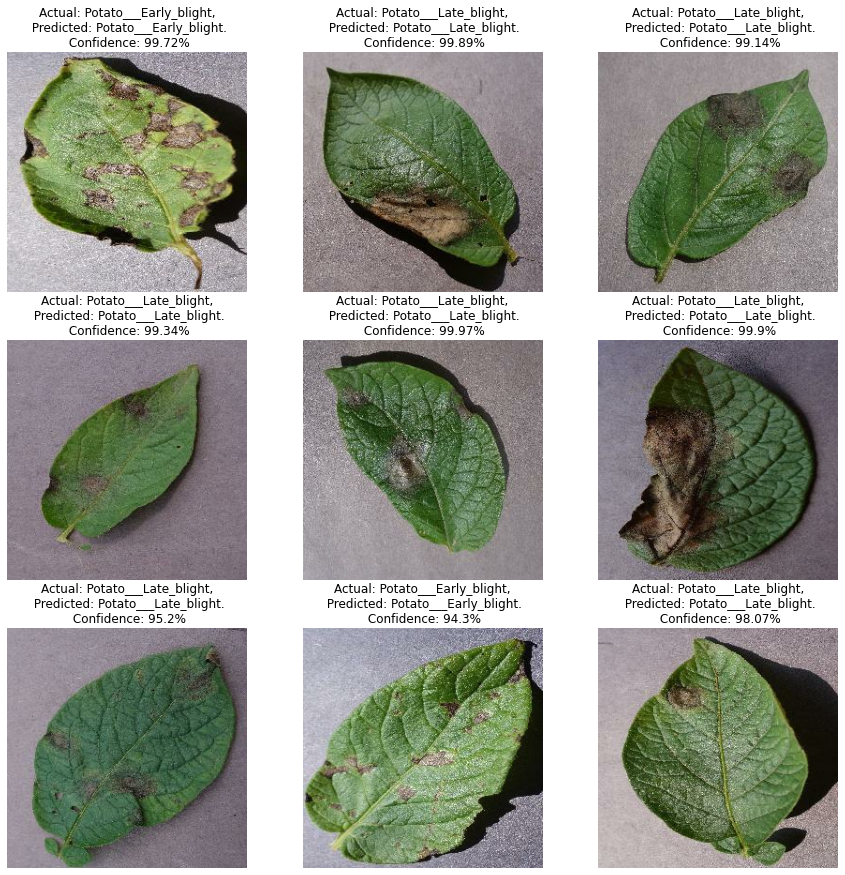

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model1, images[i])
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

Re-loading the saved model and trying it

In [ ]:
#new_model1 = tf.keras.models.load_model("drive/MyDrive/Plant village codebasics potatoes/saved_model/my_model1")
new_model1= tf.keras.models.load_model("drive/MyDrive/Plant_leaf_diseases_dataset_mendeley_potatoes/saved_model/my_model1")

In [ ]:
#Evaluate reloaded model on test_ds
scores = new_model1.evaluate(test_ds)


8/8 [==============================] - 4s 53ms/step - loss: 0.0187 - acc: 1.0000


**Ii. Buiding the ResNet50 transfer learning model**

Model Architecture

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50
from keras.optimizers import Adam
from tensorflow.keras import models, layers


model2 = models.Sequential()
model2.add(ResNet50(include_top = False, weights = 'imagenet',
                             input_shape = (IMAGE_SIZE
                                            , IMAGE_SIZE, 3)))

    
model2.add(layers.GlobalAveragePooling2D())
model2.add(layers.Dense(CHANNELS, activation = "softmax"))

model2.compile(optimizer = Adam(learning_rate = 0.00001),
                  loss = "sparse_categorical_crossentropy",
                  metrics = ["acc"])

model2.summary()

94765736/94765736 [==============================] - 0s 0us/step
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 3)                 6147      
                                                                 
Total params: 23,593,859
Trainable params: 23,540,739
Non-trainable params: 53,120
_________________________________________________________________


Callbacks

In [ ]:
import tensorflow as tf



model2_save = ModelCheckpoint('./best_baseline_model2.h5', 
                             save_best_only = True, 
                             save_weights_only = True,
                             monitor = 'val_loss', 
                             mode = 'min', verbose = 1)
early_stop2 = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, 
                           patience = 5, mode = 'min', verbose = 1,
                           restore_best_weights = True)
reduce_lr2 = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.3, 
                              patience = 2, min_delta = 0.001, 
                              mode = 'min', verbose = 1)

The training and plots

In [ ]:
history= model2.fit(train_ds,
                    validation_data= val_ds,
                    batch_size=BATCH_SIZE,
                    verbose=1,
                    epochs= 50,
                    callbacks = [model2_save, early_stop2, reduce_lr2])


# Save the entire model as a SavedModel.
#!mkdir -p saved_model
#model2.save("drive/MyDrive/Plant village  potatoes/saved_model/my_model2")
model2.save("drive/MyDrive/Plant_leaf_diseases_dataset_mendeley_potatoes/saved_model/my_model2")

Epoch 1/50
54/54 [==============================] - ETA: 0s - loss: 0.6419 - acc: 0.7324
Epoch 1: val_loss improved from inf to 0.51380, saving model to ./best_baseline_model2.h5
54/54 [==============================] - 25s 342ms/step - loss: 0.6419 - acc: 0.7324 - val_loss: 0.5138 - val_acc: 0.7760 - lr: 1.0000e-05
Epoch 2/50
54/54 [==============================] - ETA: 0s - loss: 0.1708 - acc: 0.9642
Epoch 2: val_loss improved from 0.51380 to 0.13737, saving model to ./best_baseline_model2.h5
54/54 [==============================] - 17s 304ms/step - loss: 0.1708 - acc: 0.9642 - val_loss: 0.1374 - val_acc: 0.9583 - lr: 1.0000e-05
Epoch 3/50
54/54 [==============================] - ETA: 0s - loss: 0.0856 - acc: 0.9842
Epoch 3: val_loss improved from 0.13737 to 0.08821, saving model to ./best_baseline_model2.h5
54/54 [==============================] - 17s 303ms/step - loss: 0.0856 - acc: 0.9842 - val_loss: 0.0882 - val_acc: 0.9688 - lr: 1.0000e-05
Epoch 4/50
54/54 [====================

Text(0.5, 1.0, 'Accuracy Curves')

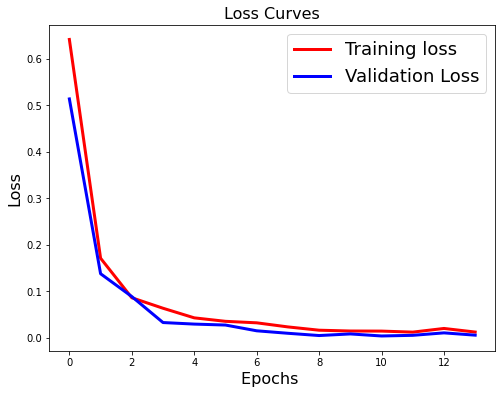

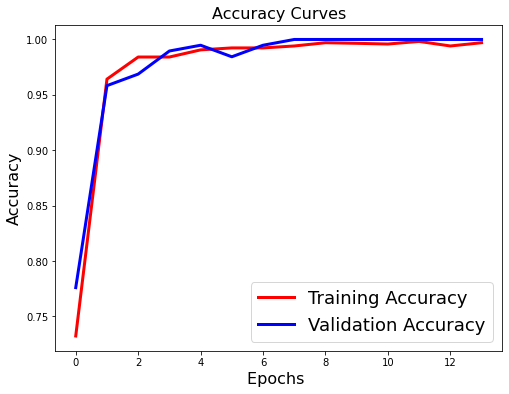

In [ ]:
#Plot the Graph
from matplotlib import pyplot as plt
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']


# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(loss,'r',linewidth=3.0)
plt.plot(val_loss,'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
  
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(accuracy,'r',linewidth=3.0)
plt.plot(val_accuracy,'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)


In [ ]:
#Evaluate model on test_ds
scores = model2.evaluate(test_ds)

8/8 [==============================] - 1s 28ms/step - loss: 0.0235 - acc: 0.9922


Now run inference on a few sample images

1/1 [==============================] - 0s 27ms/step


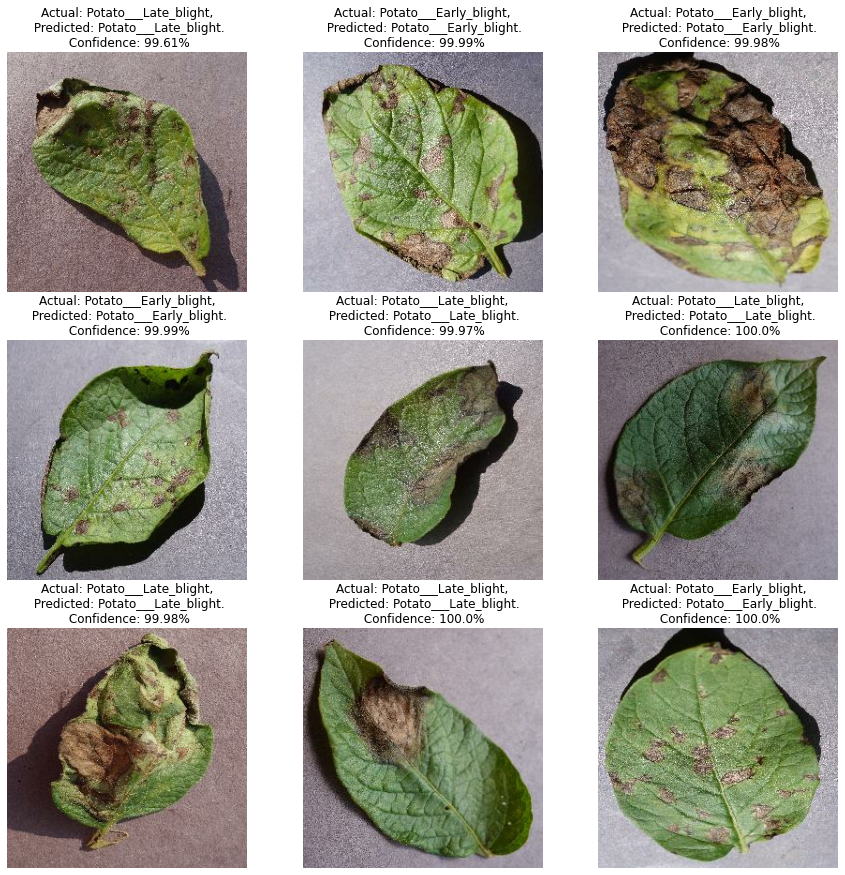

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model2, images[i])
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

**III. Building the VGG16 transfer learning model**

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import Xception
from keras.optimizers import Adam
from tensorflow.keras import models, layers


model3 = models.Sequential()
model3.add(Xception(include_top = False, weights = 'imagenet',
                             input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)))
    
model3.add(layers.GlobalAveragePooling2D())
model3.add(layers.Dense(CHANNELS, activation = "softmax"))

model3.compile(optimizer = Adam(lr = 0.001),
                  loss = "sparse_categorical_crossentropy",
                  metrics = ["acc"])

model3.summary()

83683744/83683744 [==============================] - 0s 0us/step
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 global_average_pooling2d_4   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 3)                 6147      
                                                                 
Total params: 20,867,627
Trainable params: 20,813,099
Non-trainable params: 54,528
_________________________________________________________________


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
import tensorflow as tf



model3_save = ModelCheckpoint('./best_baseline_model3.h5', 
                             save_best_only = True, 
                             save_weights_only = True,
                             monitor = 'val_loss', 
                             mode = 'min', verbose = 1)
early_stop3 = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, 
                           patience = 5, mode = 'min', verbose = 1,
                           restore_best_weights = True)
reduce_lr3 = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.3, 
                              patience = 2, min_delta = 0.001, 
                              mode = 'min', verbose = 1)

The training and plots

In [ ]:
history= model3.fit(train_ds,
                    validation_data= val_ds,
                    batch_size=BATCH_SIZE,
                    verbose=1,
                    epochs= 50,
                    callbacks = [model3_save, early_stop3, reduce_lr3])


# Save the entire model as a SavedModel.
#!mkdir -p saved_model
#model3.save("drive/MyDrive/Plant village  potatoes/saved_model/my_model3")
model3.save("drive/MyDrive/Plant_leaf_diseases_dataset_mendeley_potatoes/saved_model/my_model3")


Epoch 1/50
54/54 [==============================] - ETA: 0s - loss: 0.1319 - acc: 0.9572
Epoch 1: val_loss improved from inf to 8.25610, saving model to ./best_baseline_model3.h5
54/54 [==============================] - 35s 535ms/step - loss: 0.1319 - acc: 0.9572 - val_loss: 8.2561 - val_acc: 0.5052 - lr: 0.0010
Epoch 2/50
54/54 [==============================] - ETA: 0s - loss: 0.0797 - acc: 0.9780
Epoch 2: val_loss did not improve from 8.25610
54/54 [==============================] - 30s 537ms/step - loss: 0.0797 - acc: 0.9780 - val_loss: 21.4872 - val_acc: 0.5052 - lr: 0.0010
Epoch 3/50
54/54 [==============================] - ETA: 0s - loss: 0.0333 - acc: 0.9890
Epoch 3: val_loss improved from 8.25610 to 0.89829, saving model to ./best_baseline_model3.h5
54/54 [==============================] - 30s 534ms/step - loss: 0.0333 - acc: 0.9890 - val_loss: 0.8983 - val_acc: 0.8750 - lr: 0.0010
Epoch 4/50
54/54 [==============================] - ETA: 0s - loss: 0.0282 - acc: 0.9906
Epoch 4

Text(0.5, 1.0, 'Accuracy Curves')

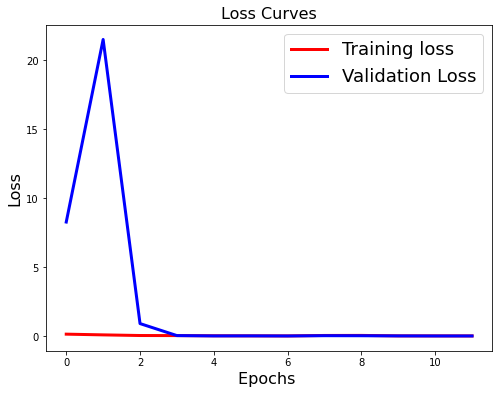

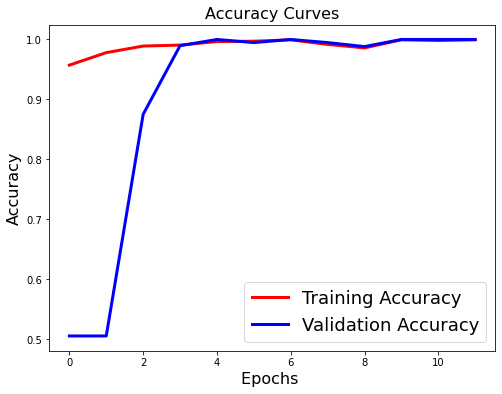

In [ ]:
#Plot the Graph
from matplotlib import pyplot as plt
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']


# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(loss,'r',linewidth=3.0)
plt.plot(val_loss,'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
  
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(accuracy,'r',linewidth=3.0)
plt.plot(val_accuracy,'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)


In [ ]:
#Evaluate model on test_ds
scores = model3.evaluate(test_ds)

8/8 [==============================] - 1s 32ms/step - loss: 1.4506e-04 - acc: 1.0000


**iv. Building the inception V3 Transfer learning model**

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import InceptionV3
from keras.optimizers import Adam
from tensorflow.keras import models, layers


model4 = models.Sequential()
model4.add(InceptionV3(include_top = False, weights = 'imagenet',
                             input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)))
    
model4.add(layers.GlobalAveragePooling2D())
model4.add(layers.Dense(CHANNELS, activation = "softmax"))

model4.compile(optimizer = Adam(lr = 0.001),
                  loss = "sparse_categorical_crossentropy",
                  metrics = ["acc"])

model4.summary()

87910968/87910968 [==============================] - 0s 0us/step
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 global_average_pooling2d_5   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_5 (Dense)             (None, 3)                 6147      
                                                                 
Total params: 21,808,931
Trainable params: 21,774,499
Non-trainable params: 34,432
_________________________________________________________________


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
import tensorflow as tf



model4_save = ModelCheckpoint('./best_baseline_model4.h5', 
                             save_best_only = True, 
                             save_weights_only = True,
                             monitor = 'val_loss', 
                             mode = 'min', verbose = 1)
early_stop4 = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, 
                           patience = 5, mode = 'min', verbose = 1,
                           restore_best_weights = True)
reduce_lr4 = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.3, 
                              patience = 2, min_delta = 0.001, 
                              mode = 'min', verbose = 1)

The training and plots

In [ ]:
history= model4.fit(train_ds,
                    validation_data= val_ds,
                    batch_size=BATCH_SIZE,
                    verbose=1,
                    epochs= 50,
                    callbacks = [model4_save, early_stop4, reduce_lr4])


# Save the entire model as a SavedModel.
#!mkdir -p saved_model
#model4.save("drive/MyDrive/Plant village  potatoes/saved_model/my_model4")
model4.save("drive/MyDrive/Plant_leaf_diseases_dataset_mendeley_potatoes/saved_model/my_model4")

Epoch 1/50
54/54 [==============================] - ETA: 0s - loss: 0.2045 - acc: 0.9300
Epoch 1: val_loss improved from inf to 46.47588, saving model to ./best_baseline_model4.h5
54/54 [==============================] - 25s 293ms/step - loss: 0.2045 - acc: 0.9300 - val_loss: 46.4759 - val_acc: 0.4635 - lr: 0.0010
Epoch 2/50
54/54 [==============================] - ETA: 0s - loss: 0.1274 - acc: 0.9595
Epoch 2: val_loss did not improve from 46.47588
54/54 [==============================] - 15s 262ms/step - loss: 0.1274 - acc: 0.9595 - val_loss: 51.4314 - val_acc: 0.4062 - lr: 0.0010
Epoch 3/50
54/54 [==============================] - ETA: 0s - loss: 0.0739 - acc: 0.9759
Epoch 3: val_loss improved from 46.47588 to 10.73450, saving model to ./best_baseline_model4.h5
54/54 [==============================] - 15s 267ms/step - loss: 0.0739 - acc: 0.9759 - val_loss: 10.7345 - val_acc: 0.4740 - lr: 0.0010
Epoch 4/50
54/54 [==============================] - ETA: 0s - loss: 0.0420 - acc: 0.9894
E

Text(0.5, 1.0, 'Accuracy Curves')

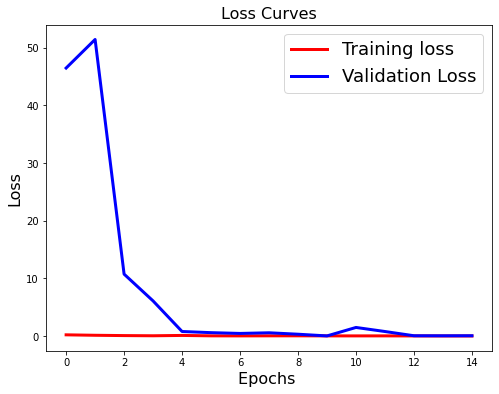

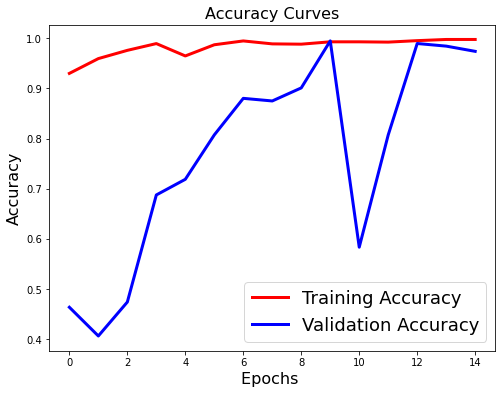

In [ ]:
#Plot the Graph
from matplotlib import pyplot as plt
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']


# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(loss,'r',linewidth=3.0)
plt.plot(val_loss,'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
  
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(accuracy,'r',linewidth=3.0)
plt.plot(val_accuracy,'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)


In [ ]:
#Evaluate model on test_ds
scores = model4.evaluate(test_ds)

8/8 [==============================] - 1s 28ms/step - loss: 0.0139 - acc: 0.9961


**v. Building the MobileNet transfer learning Model**

Model Artictecture

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import MobileNet
from keras.optimizers import Adam
from tensorflow.keras import models, layers


model5 = models.Sequential()
model5.add(MobileNet(include_top = False, weights = 'imagenet',
                             input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)))
    
model5.add(layers.GlobalAveragePooling2D())
model5.add(layers.Dense(CHANNELS, activation = "softmax"))

model5.compile(optimizer = Adam(lr = 0.001),
                  loss = "sparse_categorical_crossentropy",
                  metrics = ["acc"])

model5.summary()

17225924/17225924 [==============================] - 0s 0us/step
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 8, 8, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d_6   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 3)                 3075      
                                                                 
Total params: 3,231,939
Trainable params: 3,210,051
Non-trainable params: 21,888
_________________________________________________________________


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
import tensorflow as tf



model5_save = ModelCheckpoint('./best_baseline_model5.h5', 
                             save_best_only = True, 
                             save_weights_only = True,
                             monitor = 'val_loss', 
                             mode = 'min', verbose = 1)
early_stop5 = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, 
                           patience = 5, mode = 'min', verbose = 1,
                           restore_best_weights = True)
reduce_lr5 = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.3, 
                              patience = 2, min_delta = 0.001, 
                              mode = 'min', verbose = 1)

The training and plots

In [ ]:
history= model5.fit(train_ds,
                    validation_data= val_ds,
                    batch_size=BATCH_SIZE,
                    verbose=1,
                    epochs= 50,
                    callbacks = [model5_save, early_stop5, reduce_lr5])


# Save the entire model as a SavedModel.
#!mkdir -p saved_model
#model5.save("drive/MyDrive/Plant village  potatoes/saved_model/my_model5")
model5.save("drive/MyDrive/Plant_leaf_diseases_dataset_mendeley_potatoes/saved_model/my_model5")

Epoch 1/50
54/54 [==============================] - ETA: 0s - loss: 0.2397 - acc: 0.9354
Epoch 1: val_loss improved from inf to 23.48506, saving model to ./best_baseline_model5.h5
54/54 [==============================] - 24s 375ms/step - loss: 0.2397 - acc: 0.9354 - val_loss: 23.4851 - val_acc: 0.0677 - lr: 0.0010
Epoch 2/50
54/54 [==============================] - ETA: 0s - loss: 0.0607 - acc: 0.9821
Epoch 2: val_loss improved from 23.48506 to 12.09774, saving model to ./best_baseline_model5.h5
54/54 [==============================] - 21s 375ms/step - loss: 0.0607 - acc: 0.9821 - val_loss: 12.0977 - val_acc: 0.5625 - lr: 0.0010
Epoch 3/50
54/54 [==============================] - ETA: 0s - loss: 0.0305 - acc: 0.9878
Epoch 3: val_loss improved from 12.09774 to 3.93915, saving model to ./best_baseline_model5.h5
54/54 [==============================] - 21s 377ms/step - loss: 0.0305 - acc: 0.9878 - val_loss: 3.9391 - val_acc: 0.5938 - lr: 0.0010
Epoch 4/50
54/54 [==========================

Text(0.5, 1.0, 'Accuracy Curves')

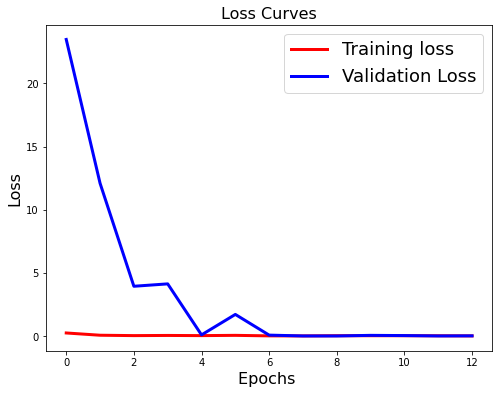

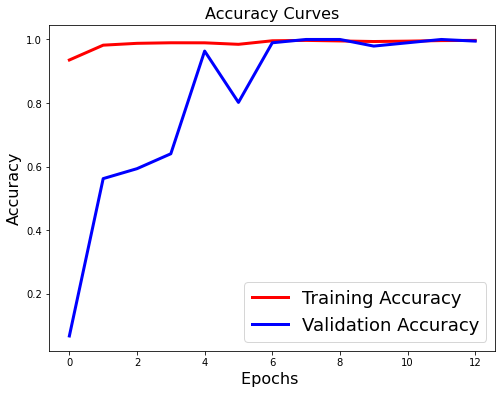

In [ ]:
#Plot the Graph
from matplotlib import pyplot as plt
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']


# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(loss,'r',linewidth=3.0)
plt.plot(val_loss,'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
  
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(accuracy,'r',linewidth=3.0)
plt.plot(val_accuracy,'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [ ]:




#Evaluate model on test_ds
scores = model5.evaluate(test_ds)

8/8 [==============================] - 1s 15ms/step - loss: 0.0093 - acc: 0.9957


  **Developing the novel stacked/ensemble transfer learning model aspect:**

**Retraining the  ResNet50  model with a new approach**

Some of the code in this section were inspired by the code in this github link: https://github.com/bnsreenu/python_for_microscopists/blob/master/144_145_binary_classification_ROC_AUC.py

Import the necessary packages

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.preprocessing.image import ImageDataGenerator
import os
import cv2
from PIL import Image
import numpy as np

Load images and their labels appropriately

In [4]:
image_directory = "drive/MyDrive/Plant_leaf_diseases_dataset_mendeley_potatoes/Plant_leave_diseases_dataset_without_augmentation/"
SIZE = 256
#define lists to hold the images and their labels
dataset = []
label = []

#Loop through each class folder and resize each image, save to the dataset list and save with appropriate label
#For the potato_early_blight folder
early_blight_images= os.listdir(image_directory + 'Potato___Early_blight/')
for i, image_name in enumerate(early_blight_images):
   if (image_name.split('.')[1] == 'JPG'):
      image = cv2.imread(image_directory + 'Potato___Early_blight/' + image_name)
      image = Image.fromarray(image, 'RGB')
      image = image.resize((SIZE, SIZE))
      dataset.append(np.array(image))
      label.append(0)
#For the potato_late_blight_folder
late_blight_images=  os.listdir(image_directory + 'Potato___Late_blight/') 
for i, image_name in enumerate(late_blight_images):
  if (image_name.split('.')[1] == 'JPG'): 
    image = cv2.imread(image_directory + 'Potato___Late_blight/' + image_name)
    image = Image.fromarray(image, 'RGB')
    image = image.resize((SIZE, SIZE)) 
    dataset.append(np.array(image))
    label.append(1)
#For the potato_healthy folder
healthy_images=  os.listdir(image_directory + 'Potato___healthy/')
for i, image_name in enumerate(healthy_images): 
  if (image_name.split('.')[1] == 'JPG'):
    image = cv2.imread(image_directory + 'Potato___healthy/' +  image_name)
    image = Image.fromarray(image, 'RGB') 
    image = image.resize((SIZE, SIZE)) 
    dataset.append(np.array(image))
    label.append(2)
    
#convert the saved lists to numpy
dataset = np.array(dataset)
label = np.array(label)

In [5]:
#Based on the indexes used for the labels,the class_names can be indexed as below
varName0= "early_blight"
varName1= "late_blight"
varName2= "healthy"
class_names= [varName0, varName1, varName2]

Split the dataset and the labels 

In [6]:
from sklearn.model_selection import train_test_split
#First split into train and test, then split Train into train and val
X_train, X_test, y_train, y_test = train_test_split(dataset, label, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2 

#Normalize the training and validation data for training convergence and optimisation
from keras.utils import normalize
X_train = normalize(X_train, axis=1)
X_test = normalize(X_val, axis=1)

Apply to_categorical() on y_train and y_valid, so as to use categorical_cross_entropy in the training

In [11]:
#from keras.utils import to_categorical
#y_train = to_categorical(y_train)
#y_val = to_categorical(y_val)

Real time Data augmentation to improve the model

In [7]:

# Define the datagenerator that would be used for the real time dynamic data augmentation
datagen= ImageDataGenerator(
    horizontal_flip= True,
    vertical_flip= True,
    rotation_range= 15
)

Weight regularization

In [12]:
import os
import tempfile

def add_regularization(model, regularizer=tf.keras.regularizers.l2(0.0001)):

    if not isinstance(regularizer, tf.keras.regularizers.Regularizer):
      print("Regularizer must be a subclass of tf.keras.regularizers.Regularizer")
      return model

    for layer in model.layers:
        for attr in ['kernel_regularizer']:
            if hasattr(layer, attr):
              setattr(layer, attr, regularizer)

    # When we change the layers attributes, the change only happens in the model config file
    model_json = model.to_json()

    # Save the weights before reloading the model.
    tmp_weights_path = os.path.join(tempfile.gettempdir(), 'tmp_weights.h5')
    model.save_weights(tmp_weights_path)

    # load the model from the config
    model = tf.keras.models.model_from_json(model_json)
    
    # Reload the model weights
    model.load_weights(tmp_weights_path, by_name=True)
    return model

Model Architecture of the ResNet50

In [13]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import  ResNet50 
from keras.optimizers import Adam
from tensorflow.keras import models, layers


model6 = models.Sequential()
model6.add( ResNet50 (include_top = False, weights = 'imagenet',
                             input_shape = (IMAGE_SIZE
                                            , IMAGE_SIZE, 3)))
#Add regularization using the function below
add_regularization(model6, regularizer=tf.keras.regularizers.l1_l2(0.0001))
    
model6.add(layers.GlobalAveragePooling2D())
model6.add(layers.Dense(CHANNELS, activation = "softmax"))

model6.compile(optimizer = Adam(learning_rate = 0.00001),
                  #loss = "categorical_crossentropy",
                  loss= "sparse_categorical_crossentropy",
                  metrics = ["acc"])

model6.summary()

94765736/94765736 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 3)                 6147      
                                                                 
Total params: 23,593,859
Trainable params: 23,540,739
Non-trainable params: 53,120
_________________________________________________________________


Defining callbacks

In [14]:
import tensorflow as tf



model6_save = ModelCheckpoint('./best_baseline_model6.h5', 
                             save_best_only = True, 
                             save_weights_only = True,
                             monitor = 'val_loss', 
                             mode = 'min', verbose = 1)
early_stop6 = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, 
                           patience = 5, mode = 'min', verbose = 1,
                           restore_best_weights = True)
reduce_lr6 = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.3, 
                              patience = 2, min_delta = 0.001, 
                              mode = 'min', verbose = 1)

The training and plots

In [15]:
history= model6.fit(datagen.flow(X_train, y_train, batch_size= 32),
                    validation_data= (X_val, y_val),
                    steps_per_epoch= len(X_train)//32,
                    epochs= 50,
                    callbacks = [model6_save, early_stop6, reduce_lr6])


# Save the entire model as a SavedModel.
#!mkdir -p saved_model
#model1.save("drive/MyDrive/Plant village  potatoes/saved_model/my_model1")
model6.save("drive/MyDrive/Plant_leaf_diseases_dataset_mendeley_potatoes/saved_model/my_model6")

Epoch 1/50
40/40 [==============================] - ETA: 0s - loss: 0.7037 - acc: 0.7146
Epoch 1: val_loss improved from inf to 0.54162, saving model to ./best_baseline_model6.h5
40/40 [==============================] - 47s 760ms/step - loss: 0.7037 - acc: 0.7146 - val_loss: 0.5416 - val_acc: 0.7981 - lr: 1.0000e-05
Epoch 2/50
40/40 [==============================] - ETA: 0s - loss: 0.2110 - acc: 0.9531
Epoch 2: val_loss improved from 0.54162 to 0.49860, saving model to ./best_baseline_model6.h5
40/40 [==============================] - 28s 679ms/step - loss: 0.2110 - acc: 0.9531 - val_loss: 0.4986 - val_acc: 0.8074 - lr: 1.0000e-05
Epoch 3/50
40/40 [==============================] - ETA: 0s - loss: 0.1090 - acc: 0.9785
Epoch 3: val_loss did not improve from 0.49860
40/40 [==============================] - 28s 708ms/step - loss: 0.1090 - acc: 0.9785 - val_loss: 1.2754 - val_acc: 0.3295 - lr: 1.0000e-05
Epoch 4/50
40/40 [==============================] - ETA: 0s - loss: 0.0750 - acc: 0.9

Text(0.5, 1.0, 'Accuracy Curves')

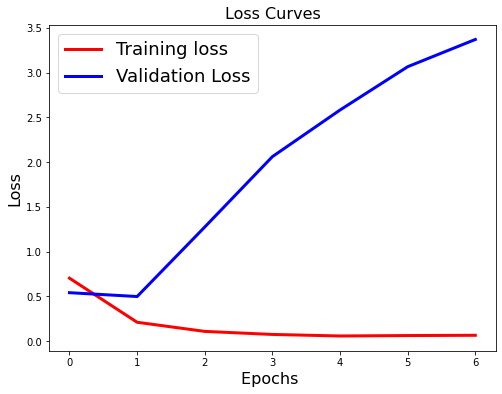

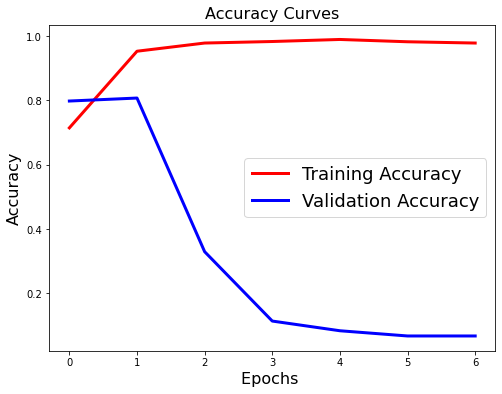

In [16]:
#Plot the Graph
from matplotlib import pyplot as plt
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']


# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(loss,'r',linewidth=3.0)
plt.plot(val_loss,'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
  
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(accuracy,'r',linewidth=3.0)
plt.plot(val_accuracy,'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

Model evaluation on test data

In [17]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model6.evaluate(X_test, y_test, batch_size=64)
print("test loss, test acc:", results)

Evaluate on test data
7/7 [==============================] - 6s 421ms/step - loss: 0.8659 - acc: 0.5081
test loss, test acc: [0.865938127040863, 0.5081206560134888]


Retrying the ResNet50 Model without data augmentation

Model Architecture

In [18]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import  ResNet50 
from keras.optimizers import Adam
from tensorflow.keras import models, layers


model6a = models.Sequential()
model6a.add( ResNet50 (include_top = False, weights = 'imagenet',
                             input_shape = (IMAGE_SIZE
                                            , IMAGE_SIZE, 3)))
#Add regularization using the function below
add_regularization(model6a, regularizer=tf.keras.regularizers.l1_l2(0.0001))
    
model6a.add(layers.GlobalAveragePooling2D())
model6a.add(layers.Dense(CHANNELS, activation = "softmax"))

model6a.compile(optimizer = Adam(learning_rate = 0.00001),
                  #loss = "categorical_crossentropy",
                  loss= "sparse_categorical_crossentropy",
                  metrics = ["acc"])

model6a.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 3)                 6147      
                                                                 
Total params: 23,593,859
Trainable params: 23,540,739
Non-trainable params: 53,120
_________________________________________________________________


Callbacks

In [19]:
import tensorflow as tf



model6a_save = ModelCheckpoint('./best_baseline_model6a.h5', 
                             save_best_only = True, 
                             save_weights_only = True,
                             monitor = 'val_loss', 
                             mode = 'min', verbose = 1)
early_stop6a = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, 
                           patience = 5, mode = 'min', verbose = 1,
                           restore_best_weights = True)
reduce_lr6a = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.3, 
                              patience = 2, min_delta = 0.001, 
                              mode = 'min', verbose = 1)

The training and plots

In [21]:
history = model6a.fit(X_train, 
                         y_train, 
                         batch_size = 32, 
                         verbose = 1, 
                         epochs = 50,      
                         validation_data=(X_val,y_val),
                         #shuffle = False,
                         callbacks = [model6a_save, early_stop6a, reduce_lr6a]
                     )



# Save the entire model as a SavedModel.
#!mkdir -p saved_model
#model1.save("drive/MyDrive/Plant village  potatoes/saved_model/my_model1")
model6a.save("drive/MyDrive/Plant_leaf_diseases_dataset_mendeley_potatoes/saved_model/my_model6a")

Epoch 1/50
41/41 [==============================] - ETA: 0s - loss: 0.5278 - acc: 0.8023
Epoch 1: val_loss improved from inf to 0.76083, saving model to ./best_baseline_model6a.h5
41/41 [==============================] - 28s 467ms/step - loss: 0.5278 - acc: 0.8023 - val_loss: 0.7608 - val_acc: 0.6450 - lr: 1.0000e-05
Epoch 2/50
41/41 [==============================] - ETA: 0s - loss: 0.1241 - acc: 0.9845
Epoch 2: val_loss improved from 0.76083 to 0.57169, saving model to ./best_baseline_model6a.h5
41/41 [==============================] - 18s 442ms/step - loss: 0.1241 - acc: 0.9845 - val_loss: 0.5717 - val_acc: 0.7471 - lr: 1.0000e-05
Epoch 3/50
41/41 [==============================] - ETA: 0s - loss: 0.0596 - acc: 0.9922
Epoch 3: val_loss did not improve from 0.57169
41/41 [==============================] - 18s 435ms/step - loss: 0.0596 - acc: 0.9922 - val_loss: 0.5932 - val_acc: 0.7749 - lr: 1.0000e-05
Epoch 4/50
41/41 [==============================] - ETA: 0s - loss: 0.0289 - acc: 0

Text(0.5, 1.0, 'Accuracy Curves')

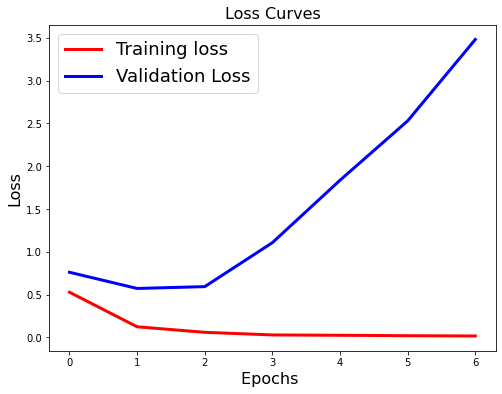

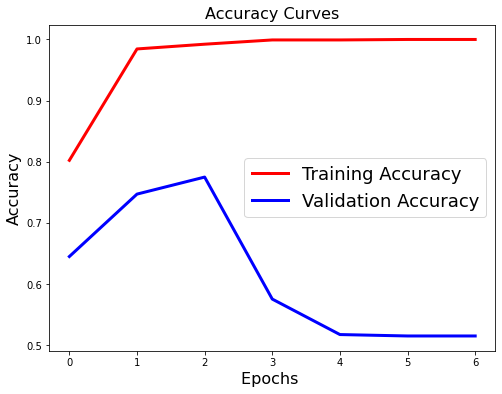

In [22]:
#Plot the Graph
from matplotlib import pyplot as plt
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']


# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(loss,'r',linewidth=3.0)
plt.plot(val_loss,'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
  
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(accuracy,'r',linewidth=3.0)
plt.plot(val_accuracy,'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

Model evaluation on test data

In [23]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model6.evaluate(X_test, y_test, batch_size=64)
print("test loss, test acc:", results)

Evaluate on test data
7/7 [==============================] - 2s 218ms/step - loss: 0.8659 - acc: 0.5081
test loss, test acc: [0.865938127040863, 0.5081206560134888]


Reloading and trying an earlier model not trained with train test split data in order to correct the overfitting issue above

In [8]:
new_model1= tf.keras.models.load_model("drive/MyDrive/Plant_leaf_diseases_dataset_mendeley_potatoes/saved_model/my_model1")

In [9]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = new_model1.evaluate(X_test, y_test, batch_size=64)
print("test loss, test acc:", results)

Evaluate on test data
7/7 [==============================] - 17s 579ms/step - loss: 1.2296 - acc: 0.5081
test loss, test acc: [1.2295674085617065, 0.5081206560134888]


**Developing the three transfer learning models that would be used to build the stacked or ensemble transfer learning model:**

The code in this section was customised from this code link: https://colab.research.google.com/gist/vardanagarwal/dfbe55382dc6051440dadf1d377f96c7/pre-trained_ensemble.ipynb

Import the dependencies

In [8]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pyplot as plt


Define constants:

In [9]:
batch_size = 32
epochs = 20
IMG_HEIGHT = 256
IMG_WIDTH = 256

In [10]:
def create_model(base_model):
    base_model.trainable = True
    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
    prediction_layer = tf.keras.layers.Dense(1, activation='softmax')(global_average_layer)
    model = tf.keras.models.Model(inputs=base_model.input, outputs=prediction_layer)
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=["accuracy"])
    return model

#history= model6.fit(datagen.flow(X_train, y_train, batch_size= 32),
                    #validation_data= (X_val, y_val),
                    #steps_per_epoch= len(X_train)//32,
                    #epochs= 50,
                    #callbacks = [model6_save, early_stop6, reduce_lr6])

def fit_model(model):
    history = model.fit(
                        datagen.flow(X_train, y_train, batch_size= 32),
                        batch_size=batch_size,
                        steps_per_epoch=len(X_train) // batch_size,
                        epochs=epochs,
                        validation_data=(X_val, y_val),
                        validation_steps=len(X_val) // batch_size
                        )
    return history 

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss=history.history['loss']
    val_loss=history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()       

In [ ]:
IMG_SHAPE = (256, 256, 3)
base_model1 = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE, include_top=False, weights="imagenet")
base_model2 = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE, include_top=False, weights="imagenet")
base_model3 = tf.keras.applications.EfficientNetB4(input_shape=IMG_SHAPE, include_top=False, weights="imagenet")

model7 = create_model(base_model1)
model8 = create_model(base_model2)
model9 = create_model(base_model3)

history7 = fit_model(model7)
#model7.save('models/model1.h5')
model7.save("drive/MyDrive/Plant_leaf_diseases_dataset_mendeley_potatoes/saved_model/my_model7")

history8 = fit_model(model8)
#model2.save('models/model2.h5')
model8.save("drive/MyDrive/Plant_leaf_diseases_dataset_mendeley_potatoes/saved_model/my_model8")

history9 = fit_model(model9)
#model3.save('models/model3.h5')
model9.save("drive/MyDrive/Plant_leaf_diseases_dataset_mendeley_potatoes/saved_model/my_model9")

71686520/71686520 [==============================] - 4s 0us/step


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/20


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


40/40 [==============================] - 44s 663ms/step - loss: nan - accuracy: 0.4555 - val_loss: nan - val_accuracy: 0.5192
Epoch 2/20
40/40 [==============================] - 26s 634ms/step - loss: nan - accuracy: 0.4571 - val_loss: nan - val_accuracy: 0.5192
Epoch 3/20
40/40 [==============================] - 23s 580ms/step - loss: nan - accuracy: 0.4531 - val_loss: nan - val_accuracy: 0.5192
Epoch 4/20
40/40 [==============================] - 24s 598ms/step - loss: nan - accuracy: 0.4531 - val_loss: nan - val_accuracy: 0.5192
Epoch 5/20
40/40 [==============================] - 25s 627ms/step - loss: nan - accuracy: 0.4563 - val_loss: nan - val_accuracy: 0.5192
Epoch 6/20
40/40 [==============================] - 23s 576ms/step - loss: nan - accuracy: 0.4571 - val_loss: nan - val_accuracy: 0.5192
Epoch 7/20
40/40 [==============================] - 24s 591ms/step - loss: nan - accuracy: 0.4531 - val_loss: nan - val_accuracy: 0.5192
Epoch 8/20
40/40 [==============================] - 

Epoch 1/20


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


40/40 [==============================] - 40s 663ms/step - loss: nan - accuracy: 0.4547 - val_loss: nan - val_accuracy: 0.5192
Epoch 2/20
40/40 [==============================] - 23s 572ms/step - loss: nan - accuracy: 0.4531 - val_loss: nan - val_accuracy: 0.5192
Epoch 3/20
40/40 [==============================] - 23s 566ms/step - loss: nan - accuracy: 0.4531 - val_loss: nan - val_accuracy: 0.5192
Epoch 4/20
40/40 [==============================] - 22s 540ms/step - loss: nan - accuracy: 0.4539 - val_loss: nan - val_accuracy: 0.5192
Epoch 5/20
40/40 [==============================] - 22s 539ms/step - loss: nan - accuracy: 0.4571 - val_loss: nan - val_accuracy: 0.5192
Epoch 6/20
40/40 [==============================] - 22s 551ms/step - loss: nan - accuracy: 0.4579 - val_loss: nan - val_accuracy: 0.5192
Epoch 7/20
40/40 [==============================] - 23s 568ms/step - loss: nan - accuracy: 0.4579 - val_loss: nan - val_accuracy: 0.5192
Epoch 8/20
40/40 [==============================] - 

Epoch 1/20


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


40/40 [==============================] - 180s 4s/step - loss: nan - accuracy: 0.4714 - val_loss: nan - val_accuracy: 0.5192
Epoch 2/20
40/40 [==============================] - 40s 973ms/step - loss: nan - accuracy: 0.4610 - val_loss: nan - val_accuracy: 0.5192
Epoch 3/20
40/40 [==============================] - 39s 959ms/step - loss: nan - accuracy: 0.4563 - val_loss: nan - val_accuracy: 0.5192
Epoch 4/20
40/40 [==============================] - 39s 966ms/step - loss: nan - accuracy: 0.4547 - val_loss: nan - val_accuracy: 0.5192
Epoch 5/20
40/40 [==============================] - 39s 970ms/step - loss: nan - accuracy: 0.4539 - val_loss: nan - val_accuracy: 0.5192
Epoch 6/20
40/40 [==============================] - 39s 956ms/step - loss: nan - accuracy: 0.4603 - val_loss: nan - val_accuracy: 0.5192
Epoch 7/20
40/40 [==============================] - 40s 979ms/step - loss: nan - accuracy: 0.4523 - val_loss: nan - val_accuracy: 0.5192
Epoch 8/20
40/40 [==============================] - 39

In [ ]:
plot_history(history7)
plot_history(history8)
plot_history(history9)

The experiment to develop a novel stacked/ensemble transfer learning model failed, as the method used was overfitting and not performing well, despite all attempts to correct this, and also the three integrated transfer learning models caused my google colab to crash with the error message that i used up all available ram, so I will deploy the model using the saved model of the best performing transfer learning model from the last section, the VGG16 (its my_model3)